In [6]:

from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra

import pingouin as pg
from fooof import FOOOFGroup
from natsort import natsorted

from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
#plt.ioff()
import seaborn as sns
import contextlib
import arviz as az
import pymc as pm

#import bambi as bmb



# all these imports are needed (for some fucking weird reason the toolbox throws an error otherwise)
import pyhrv
#import pyhrv.frequency_domain as fd
#import pyhrv.time_domain as td
#import pyhrv.tools as tools
#import biosppy

#%matplotlib inline

# use pyhrv standard settings (or at least what was suggested on the website)
settings_time = {
    'threshold': 50,            # Computation of NNXX/pNNXX with 50 ms threshold -> NN50 & pNN50
    'plot': False,               # If True, plots NNI histogram
    'binsize': 7.8125           # Binsize of the NNI histogram
    }

    # Frequency Domain Settings
settings_welch = {
    'nfft': 2 ** 12,            # Number of points computed for the FFT result
    'detrend': True,
    'show': False,
    'show_param': False, 
    'legend':False,           # If True, detrend NNI series by subtracting the mean NNI
    'window': 'hanning'         # Window function used for PSD estimation
    }

settings_lomb = {
        'nfft': 2**8, 
        'show': False,
        'show_param': False, 
        'legend':False,                 # Number of points computed for the Lomb PSD
        'ma_size': 5                # Moving average window size
    }

settings_ar = {
        'nfft': 2**12,
        'show': False,
        'show': False,
        'show_param': False, 
        'legend':False,                # Number of points computed for the AR PSD
        'order': 32                 # AR order
    }

    # Nonlinear Parameter Settings
settings_nonlinear = {
        'short': [4, 16],           # Interval limits of the short term fluctuations
        'long': [17, 64], 
        'legend':False,            # Interval limits of the long term fluctuations
        'dim': 2,                   # Sample entropy embedding dimension
        'tolerance': None           # Tolerance distance for which the vectors to be considered equal (None sets default values)
    }

In [7]:
DATA_DIR = './data/data_ecg_only/'
FS = 1000
subject_info = pd.read_csv(join(DATA_DIR, 'subject-info.csv'))

all_files = natsorted(listdir(DATA_DIR))

all_data = np.array([file[:-4] for file in all_files if '.dat' in file])

#s_info = subject_info[subject_info['Length'] > 10]
#s_info = s_info[s_info['Device'] == 1]
#select only recordings of at least 12 mins
#all_data = [data for data in all_data if int(data) in s_info['ID']]

In [8]:
#%%capture
psd_data, hrv_data = [], []
skip_hrv = True

for idx, data in enumerate(all_data):
    #idx, data = 0, all_data[0]
    print(f'Current file is: {idx}')

    data_record = wfdb.rdsamp(join(DATA_DIR, data))

    cur_data = data_record[0][:,0]
    times = create_times(len(data_record[0])/FS, FS)
    
    cur_data = cur_data[times < subject_info['Length'].min()*60]
    
    #Compute standard hrv data
    if skip_hrv == False:

        try:
            all_outputs = ['nni_counter', 'nni_mean', 'nni_min', 'nni_max', 'hr_mean', 'hr_min', 'hr_max',
                        'hr_std', 'nni_diff_mean','nni_diff_min', 'nni_diff_max', 'sdnn', 'sdnn_index', 'sdann',
                        'rmssd', 'sdsd', 'nn50','pnn50','nn20','pnn20', 'sd1', 'sd2', 'sd_ratio',
                        'ellipse_area', 'sampen', 'dfa_alpha1', 'dfa_alpha2', 'fft_ratio', 'fft_total']
            #Compute standard hrv data
            results = pyhrv.hrv(signal=cur_data,
                                kwargs_time=settings_time,
                                kwargs_welch=settings_welch,
                                kwargs_ar=settings_ar,
                                kwargs_lomb=settings_lomb,
                                kwargs_nonlinear=settings_nonlinear,
                                plot_ecg=False,
                                plot_tachogram=False,
                                show=False,
                                );
            cur_df = pd.DataFrame({output: results[output] for output in all_outputs}, index=[idx])
            cur_df['subject_id'] = idx

            #get frequency output
            freq_output = ['fft_peak', 'fft_abs', 'fft_rel', 'fft_log',
                        'lomb_peak', 'lomb_abs', 'lomb_rel', 'lomb_log',
                        'ar_peak', 'ar_abs', 'ar_rel', 'ar_log',]

            freq_dfs = []
            for f_out in freq_output:
                cur_res = results[f_out]
                freq_dfs.append(pd.DataFrame({f'vlf_{f_out}': cur_res[0],
                                              f'lf_{f_out}': cur_res[1],
                                              f'hf_{f_out}': cur_res[2]}, index=[0])) #index 0 is important here
            df_freq_cmb = pd.concat(freq_dfs, axis=1)
            df_freq_cmb['subject_id'] = idx

            cur_df_cmb = cur_df.merge(df_freq_cmb, on='subject_id')
                               
            hrv_data.append(cur_df_cmb)
     
        except ValueError:
            hrv_data.append(pd.DataFrame(dict(zip(all_outputs, np.ones(len(all_outputs)) * np.nan)), index=[idx]))

    nperseg = FS*10
    freq_med, psd_med = compute_spectrum(cur_data, FS, method='welch', avg_type='median', nperseg=nperseg, noverlap=nperseg/2) #
    psd_data.append(psd_med)

Current file is: 0
Current file is: 1
Current file is: 2
Current file is: 3
Current file is: 4
Current file is: 5
Current file is: 6
Current file is: 7
Current file is: 8
Current file is: 9
Current file is: 10
Current file is: 11
Current file is: 12
Current file is: 13
Current file is: 14
Current file is: 15
Current file is: 16
Current file is: 17
Current file is: 18
Current file is: 19
Current file is: 20
Current file is: 21
Current file is: 22
Current file is: 23
Current file is: 24
Current file is: 25
Current file is: 26
Current file is: 27
Current file is: 28
Current file is: 29
Current file is: 30
Current file is: 31
Current file is: 32
Current file is: 33
Current file is: 34
Current file is: 35
Current file is: 36
Current file is: 37
Current file is: 38
Current file is: 39
Current file is: 40
Current file is: 41
Current file is: 42
Current file is: 43
Current file is: 44
Current file is: 45
Current file is: 46
Current file is: 47
Current file is: 48
Current file is: 49
Current fi

In [9]:
def interpolate_line_freq(signal, line_freq, freqs, freq_res):
    '''
    This function takes a power spectrum and interpolates the powerline noise.
    This is done by replacing the value at the powerline freq with the value 1Hz before.
    '''
    freq_steps = int(1 / freq_res)
    interpol = signal.copy()
    for idx, cur_freq in enumerate(freqs):
        if cur_freq % line_freq == 0 and idx > 0:
            interpol[idx-freq_steps:idx+freq_steps] = signal[idx-freq_steps]

    return interpol

In [10]:
psd_new = [interpolate_line_freq(cur_data, 50, freq_med, 0.1) for cur_data in psd_data]

In [11]:
df_psd = pd.DataFrame(np.transpose(psd_new))
df_psd['Frequency (Hz)'] = freq_med
df_psd_tidy = df_psd.melt(id_vars='Frequency (Hz)')

/mnt/obob/staff/fschmidt/miniconda3/envs/ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


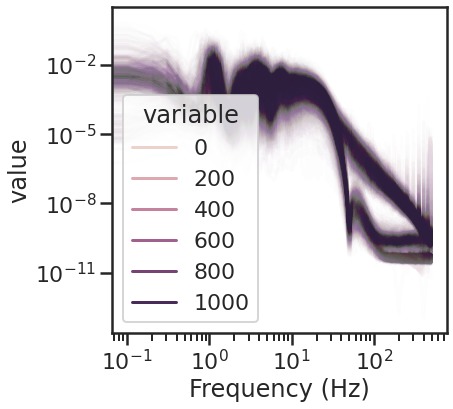

In [50]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='value',
             hue="variable", alpha=0.05,
             data=df_psd_tidy, ax=ax)
fig.set_size_inches(6,6)
plt.xscale('log')
plt.yscale('log')
fig.savefig('./results/ind_subs_psd_ecg_only.svg')

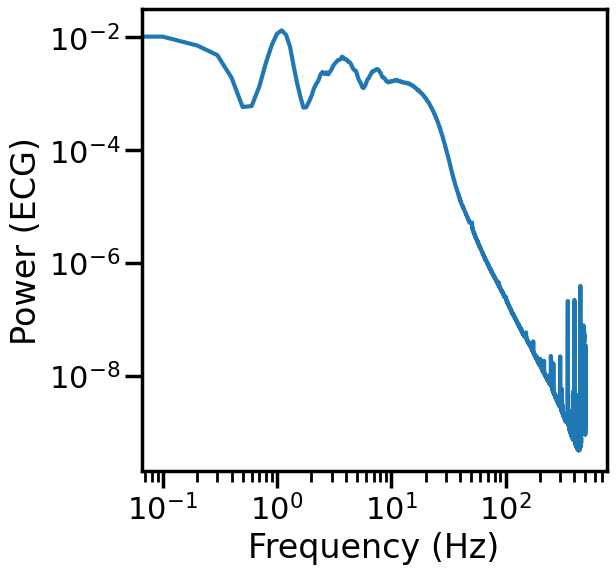

In [12]:

sns.set_context('poster')

error = np.nanstd(psd_new, axis=0)
y = np.nanmean(psd_new, axis=0)

fig, ax = plt.subplots()
ax.loglog(freq_med, y);
ax.set_ylabel('Power (ECG)')
ax.set_xlabel('Frequency (Hz)')
fig.set_size_inches(6,6)
fig.savefig('./results/ga_ecg_psd.svg')

In [13]:
psd2fooof = np.array(psd_new)
good_files = [~(np.isnan(file).sum() > 0) for file in psd2fooof] #only take spectra without nans
psd2fooof = psd2fooof[good_files]

#Get good idcs in subject info
good_idcs = [int(file) for file in np.array(all_data)[good_files]]
subject_info_clean = subject_info.loc[subject_info['ID'].isin(good_idcs)]

In [14]:
if skip_hrv == False:
    df_hrv = pd.concat(hrv_data)
    df_hrv.to_csv('hrv_data_ecg_only.csv')
else:
    df_hrv = pd.read_csv('hrv_data_ecg_only.csv')

df_hrv_clean = df_hrv.loc[good_files]
good_idx_hrv = df_hrv['hr_mean'] > 20
(good_idx_hrv != good_files).sum()

0

In [18]:
d_0_corr, d_1_corr, exps_list, d_cmb_corr = [],[],[],[]

#remove outliers
def check_outliers(data, thresh):
    """Calculate indices of outliers, as defined by a standard deviation threshold. Similar as in Donoghue et al. 2020.
    Yet slightly different. Function returns an array of bools indicating whether or not the error or r2 is an outlier.
    True if the parameter is an inlier"""

    return np.abs(data - np.mean(data)) < thresh * np.std(data)

def get_good_idx(fg, thresh):
    r2 = check_outliers(fg.get_params('r_squared'), thresh)
    err = check_outliers(fg.get_params('error'), thresh)
    good_idx = r2 * err
    return good_idx

for freq in [50, 100, 150, 200, 250, 300, 350, 400]:
    fg = FOOOFGroup(max_n_peaks=0)#, aperiodic_mode='knee')
    fg.fit(freq_med, psd2fooof, freq_range=(0.1, freq), progress='tqdm')

    aps = pd.DataFrame(fg.get_params('aperiodic_params'))
    aps.columns = ['Offset', 'Exponent'] #'Knee',

    exps_list.append(aps['Exponent'])

    s_info_clean = subject_info_clean.loc[get_good_idx(fg, thresh=2)].reset_index()
    aps_clean = aps.loc[get_good_idx(fg, thresh=2)].reset_index()
    df_hrv_clean2 = df_hrv_clean.loc[get_good_idx(fg, thresh=2)].reset_index()

    df_cmb = pd.concat([aps_clean, s_info_clean, df_hrv_clean2], axis=1)

    d_0 = df_cmb.query('Device == 0')
    d_1 = df_cmb.query('Device == 1')

    d_cmb_corr.append(pg.corr(df_cmb['Exponent'], df_cmb['Age_group'])['r'])
    d_0_corr.append(pg.corr(d_0['Exponent'], d_0['Age_group'])['r'])
    d_1_corr.append(pg.corr(d_1['Exponent'], d_1['Age_group'])['r'])

Running FOOOFGroup: 100%|██████████| 1105/1105 [00:26<00:00, 41.68it/s]


/tmp/ipykernel_1027/3300221334.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(freqs, rotation = 90)


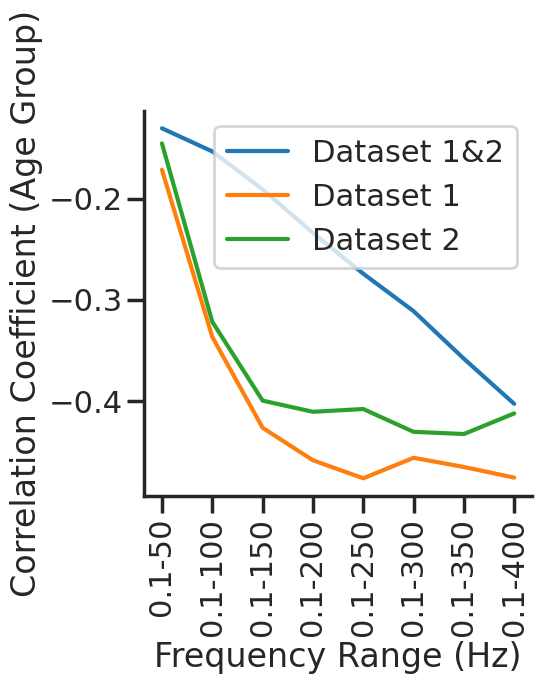

In [20]:
sns.set_style('ticks')
#sns.set_context('talk')


freqs = ['0.1-50', '0.1-100', '0.1-150', '0.1-200', '0.1-250', '0.1-300', '0.1-350', '0.1-400']
#freqs = ['0.01-20', '20-400', '0.01-400']#['0.1-2', '0.1-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400']
fig, ax = plt.subplots()
 
ax.plot(freqs, np.array(d_cmb_corr).flatten(), label='Dataset 1&2')
ax.plot(freqs, np.array(d_0_corr).flatten(), label='Dataset 1')
ax.plot(freqs, np.array(d_1_corr).flatten(), label='Dataset 2')
ax.set_ylabel('Correlation Coefficient (Age Group)')
ax.set_xlabel('Frequency Range (Hz)')
ax.legend()
ax.set_xticklabels(freqs, rotation = 90)
fig.set_size_inches(5, 5)
sns.despine()
fig.savefig('./results/corr_age_freq_range_ecg_only_hf.svg')

In [12]:
d_0 = df_cmb.query('Device == 0')

In [19]:
d_0_corr

[pearson   -0.17154
 Name: r, dtype: float64,
 pearson   -0.336721
 Name: r, dtype: float64,
 pearson   -0.426527
 Name: r, dtype: float64,
 pearson   -0.458639
 Name: r, dtype: float64,
 pearson   -0.476458
 Name: r, dtype: float64,
 pearson   -0.456215
 Name: r, dtype: float64,
 pearson   -0.465286
 Name: r, dtype: float64,
 pearson   -0.475795
 Name: r, dtype: float64]

In [17]:
d_0_corr

[pearson   -0.172258
 Name: r, dtype: float64,
 pearson   -0.317237
 Name: r, dtype: float64,
 pearson   -0.411621
 Name: r, dtype: float64,
 pearson   -0.444048
 Name: r, dtype: float64,
 pearson   -0.459277
 Name: r, dtype: float64,
 pearson   -0.457046
 Name: r, dtype: float64,
 pearson   -0.465189
 Name: r, dtype: float64,
 pearson   -0.47488
 Name: r, dtype: float64]

In [13]:
pd.concat(exps_list, axis=1).corr()

,Exponent,Exponent,Exponent,Exponent,Exponent,Exponent,Exponent,Exponent,Exponent
Exponent,1.000000,-0.532327,-0.525509,-0.490553,-0.462785,-0.427559,-0.376915,-0.297786,-0.169031
Exponent,-0.532327,1.000000,0.911050,0.869839,0.833266,0.786023,0.716137,0.597695,0.397567
Exponent,-0.525509,0.911050,1.000000,0.981406,0.952856,0.911270,0.845250,0.728014,0.520651
Exponent,-0.490553,0.869839,0.981406,1.000000,0.990195,0.964387,0.914569,0.815826,0.626889
Exponent,-0.462785,0.833266,0.952856,0.990195,1.000000,0.990549,0.957707,0.879071,0.712515
Exponent,-0.427559,0.786023,0.911270,0.964387,0.990549,1.000000,0.987281,0.933063,0.795293
Exponent,-0.376915,0.716137,0.845250,0.914569,0.957707,0.987281,1.000000,0.977745,0.879272
Exponent,-0.297786,0.597695,0.728014,0.815826,0.879071,0.933063,0.977745,1.000000,0.958930
Exponent,-0.169031,0.397567,0.520651,0.626889,0.712515,0.795293,0.879272,0.958930,1.000000


In [14]:
pg.corr(d_0['Exponent'], d_0['Age_group'])['r']

pearson   -0.475795
Name: r, dtype: float64

In [15]:

def do_heart2plot(df):

    heart2plot = pd.DataFrame(df.corr()['Exponent'])[5:].reset_index()
    heart2plot.columns = ['Heart Rate Components', 'Correlation']


    drop_list = ['Sex', 'Length', 'BMI', 'Device', 'index', 'Unnamed: 0', 'sdnn', 'sdnn_index', 'sdann',
    'rmssd', 'sdsd', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area', 'dfa_alpha1',
    'dfa_alpha2', 'fft_ratio', 'fft_total', 'subject_id', 'vlf_lomb_peak',
    'lf_lomb_peak', 'hf_lomb_peak', 'vlf_lomb_abs', 'lf_lomb_abs',
    'hf_lomb_abs', 'vlf_lomb_rel', 'lf_lomb_rel', 'hf_lomb_rel',
    'vlf_lomb_log', 'lf_lomb_log', 'hf_lomb_log', 'vlf_ar_peak',
    'lf_ar_peak', 'hf_ar_peak', 'vlf_ar_abs', 'lf_ar_abs', 'hf_ar_abs',
    'vlf_ar_rel', 'lf_ar_rel', 'hf_ar_rel', 'vlf_ar_log', 'lf_ar_log',
    'hf_ar_log','vlf_fft_peak','lf_fft_peak', 'hf_fft_peak', 'vlf_fft_abs', 
    'lf_fft_abs','hf_fft_abs', 'vlf_fft_rel', 'lf_fft_rel', 'hf_fft_rel',]

    heart2plot.drop(heart2plot[heart2plot['Heart Rate Components'].isin(drop_list)].index, inplace=True)
    relabel_list_heart = ['Age', 'RR-Interval (Counts)', 'RR-Interval (mean)', 'RR-Interval (min)', 'RR-Interval (max)',
                    'Heart Rate (mean)', 'Heart Rate (min)', 'Heart Rate (max)', 'Heart Rate (std)',
                    'RR-Interval Δ (mean)','RR-Interval Δ (min)', 'RR-Interval Δ (max)',  'RR-Interval > 50ms', 
                    'RR-Interval > 50ms (ratio)', 'RR-Interval > 20ms', 'RR-Interval > 20ms (ratio)', 'Sample Entropy',
                    'VLF (0 - 0.04Hz)', 'LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)']

    heart2plot['Heart Rate Components'] = heart2plot['Heart Rate Components'].replace(dict(zip(heart2plot['Heart Rate Components'], relabel_list_heart)))
    return heart2plot

hcorr_1 = do_heart2plot(d_0)
hcorr_2 = do_heart2plot(d_1)
hcorr = do_heart2plot(df_cmb)

In [16]:
heart2plot = hcorr.copy()
#heart2plot['Correlation'] = np.mean([hcorr_1['Correlation'], hcorr_2['Correlation']], axis=0)

(-0.3, 0.3)

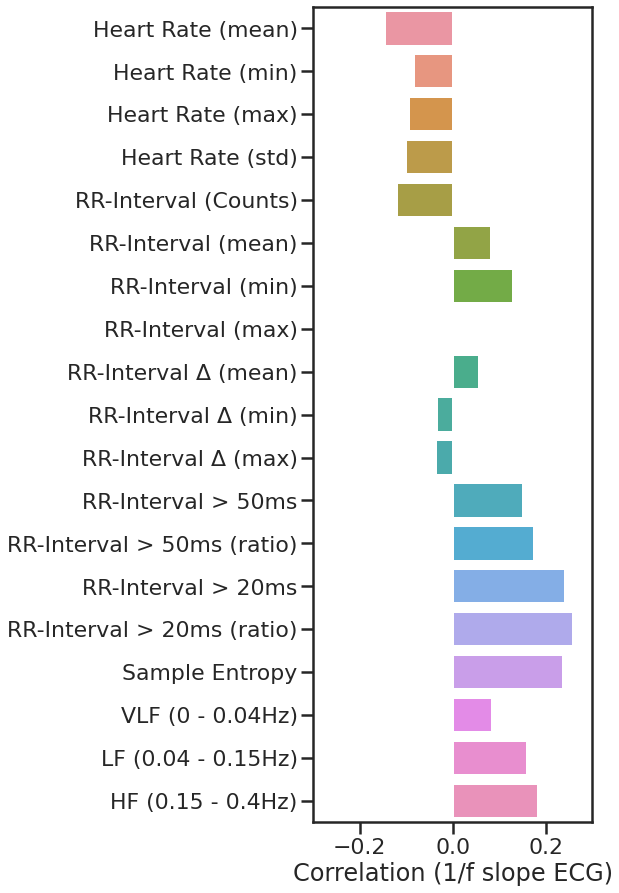

In [17]:
plot_order = ['Heart Rate (mean)', 'Heart Rate (min)', 'Heart Rate (max)', 'Heart Rate (std)',
              'RR-Interval (Counts)', 'RR-Interval (mean)', 'RR-Interval (min)', 'RR-Interval (max)',  
              'RR-Interval Δ (mean)','RR-Interval Δ (min)', 'RR-Interval Δ (max)', 'RR-Interval > 50ms', 
              'RR-Interval > 50ms (ratio)', 'RR-Interval > 20ms', 'RR-Interval > 20ms (ratio)', 'Sample Entropy',
              'VLF (0 - 0.04Hz)', 'LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)']


g = sns.barplot(data=heart2plot, y='Heart Rate Components', x='Correlation', order=plot_order)
g.set_xlabel('Correlation (1/f slope ECG)')
g.set_ylabel('')
g.figure.set_size_inches(5, 15)
g.set_xlim(-.3,.3)

In [27]:
#channel_idxs, channel = pd.factorize(df['channel'])
df2baycor = df_cmb.copy()

drop_list = ['Offset', 'ID', 'Sex', 'Length', 'BMI', 'Device', 'index', 'Unnamed: 0', 'sdnn', 'sdnn_index', 'sdann',
    'rmssd', 'sdsd', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area', 'dfa_alpha1',
    'dfa_alpha2', 'fft_ratio', 'fft_total', 'subject_id', 'vlf_lomb_peak',
    'lf_lomb_peak', 'hf_lomb_peak', 'vlf_lomb_abs', 'lf_lomb_abs',
    'hf_lomb_abs', 'vlf_lomb_rel', 'lf_lomb_rel', 'hf_lomb_rel',
    'vlf_lomb_log', 'lf_lomb_log', 'hf_lomb_log', 'vlf_ar_peak',
    'lf_ar_peak', 'hf_ar_peak', 'vlf_ar_abs', 'lf_ar_abs', 'hf_ar_abs',
    'vlf_ar_rel', 'lf_ar_rel', 'hf_ar_rel', 'vlf_ar_log', 'lf_ar_log',
    'hf_ar_log','vlf_fft_peak','lf_fft_peak', 'hf_fft_peak', 'vlf_fft_abs', 
    'lf_fft_abs','hf_fft_abs', 'vlf_fft_rel', 'lf_fft_rel', 'hf_fft_rel',]

df2baycor.drop(drop_list, axis=1, inplace=True)

relabel_list_heart = ['Exponent', 'Age', 'RR-Interval (Counts)', 'RR-Interval (mean)', 'RR-Interval (min)', 'RR-Interval (max)',
                    'Heart Rate (mean)', 'Heart Rate (min)', 'Heart Rate (max)', 'Heart Rate (std)',
                    'RR-Interval Δ (mean)','RR-Interval Δ (min)', 'RR-Interval Δ (max)',  'RR-Interval > 50ms', 
                    'RR-Interval > 50ms (ratio)', 'RR-Interval > 20ms', 'RR-Interval > 20ms (ratio)', 'Sample Entropy',
                    'VLF (0 - 0.04Hz)', 'LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)']

df2baycor.columns = relabel_list_heart
df2baycor

,Exponent,Age,RR-Interval (Counts),RR-Interval (mean),RR-Interval (min),RR-Interval (max),Heart Rate (mean),Heart Rate (min),Heart Rate (max),Heart Rate (std),...,RR-Interval Δ (min),RR-Interval Δ (max),RR-Interval > 50ms,RR-Interval > 50ms (ratio),RR-Interval > 20ms,RR-Interval > 20ms (ratio),Sample Entropy,VLF (0 - 0.04Hz),LF (0.04 - 0.15Hz),HF (0.15 - 0.4Hz)
0,3.173467,2.0,561.0,852.327986,690.0,1091.0,70.769264,54.995417,86.956522,5.166207,...,0.0,317.0,217.0,38.750000,418.0,74.642857,1.846071,6.536526,7.139402,6.762343
1,3.485675,2.0,528.0,906.767045,738.0,1175.0,66.595539,51.063830,81.300813,5.361782,...,0.0,280.0,277.0,52.561670,426.0,80.834915,2.040893,6.836256,7.374029,7.066754
2,3.309246,7.0,738.0,648.520325,633.0,669.0,92.526697,89.686099,94.786730,0.881236,...,0.0,15.0,0.0,0.000000,0.0,0.000000,1.395846,0.855063,2.068618,2.783075
3,3.716574,4.0,491.0,975.175153,783.0,1237.0,61.796633,48.504446,76.628352,4.096566,...,0.0,187.0,104.0,21.224490,309.0,63.061224,1.625907,7.080429,6.734558,6.793763
4,3.606341,2.0,530.0,903.511321,676.0,1233.0,67.038132,48.661800,88.757396,6.606158,...,0.0,463.0,347.0,65.595463,467.0,88.279773,1.407525,6.470970,6.813305,8.083580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,3.724030,3.0,598.0,800.469900,651.0,996.0,75.253922,60.240964,92.165899,4.668913,...,0.0,172.0,91.0,15.242881,300.0,50.251256,1.296802,6.001429,7.115782,6.015908
1063,3.106831,8.0,726.0,659.816804,629.0,687.0,90.954620,87.336245,95.389507,1.359915,...,0.0,22.0,0.0,0.000000,1.0,0.137931,1.736216,3.520213,2.224889,3.723538
1064,3.824470,2.0,611.0,783.648118,242.0,964.0,77.093930,62.240664,247.933884,8.785350,...,0.0,547.0,32.0,5.245902,241.0,39.508197,1.345589,6.795646,6.987730,6.127489
1065,3.429080,3.0,433.0,1104.718245,855.0,1757.0,54.613890,34.149118,70.175439,3.993413,...,0.0,678.0,139.0,32.175926,322.0,74.537037,1.515351,7.158915,7.782540,7.066426


In [39]:
#Calculate bayesian correlation

coords = {'vars': list(df2baycor.keys())}

with pm.Model(coords=coords) as correlation_model:
    #channel_num = pm.Data('channel_num', df2baycor.columns, dims='channel', mutable=False)

    # set some more or less informative priors here
    mu = pm.Normal('mu', mu=0, sigma=10., dims='vars') #

    #prior on correlation
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=len(df2baycor.columns), eta=4.0, 
                   sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True)
    
    #observed data
    y = pm.MvNormal('y', mu=mu, chol=chol, observed=df2baycor)

/mnt/obob/staff/fschmidt/miniconda3/envs/ml/lib/python3.9/site-packages/pymc/model.py:1365: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


NotImplementedError: Automatic inputation is only supported for univariate RandomVariables, but y is multivariate

['Exponent',
 'Age',
 'RR-Interval (Counts)',
 'RR-Interval (mean)',
 'RR-Interval (min)',
 'RR-Interval (max)',
 'Heart Rate (mean)',
 'Heart Rate (min)',
 'Heart Rate (max)',
 'Heart Rate (std)',
 'RR-Interval Δ (mean)',
 'RR-Interval Δ (min)',
 'RR-Interval Δ (max)',
 'RR-Interval > 50ms',
 'RR-Interval > 50ms (ratio)',
 'RR-Interval > 20ms',
 'RR-Interval > 20ms (ratio)',
 'Sample Entropy',
 'VLF (0 - 0.04Hz)',
 'LF (0.04 - 0.15Hz)',
 'HF (0.15 - 0.4Hz)']

In [15]:
df_cmb.corr()['Age_group'].sort_values()[:10]

nn20          -0.459967
pnn20         -0.413927
Exponent      -0.402906
Offset        -0.375184
nn50          -0.296835
sampen        -0.294352
lf_fft_peak   -0.294324
pnn50         -0.286276
hf_fft_log    -0.283745
lf_fft_log    -0.277572
Name: Age_group, dtype: float64

In [16]:
md = bmb.Model(formula='Age_group ~ 1 + Exponent + lf_fft_log + hf_fft_log + nn20 + nn50 + sampen', dropna=True,  data=df_cmb)
mdf = md.fit()
md.predict(mdf, kind='pps')

Automatically removing 24/1067 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, Exponent, lf_fft_log, hf_fft_log, nn20, nn50, sampen, Age_group_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


In [23]:
y_true = mdf.observed_data["Age_group"].values
y_pred = mdf.posterior_predictive.stack(sample=("chain", "draw"))["Age_group"].values.T
print(az.r2_score(y_true, y_pred))
samples = mdf.posterior

df_cmb.dropna(inplace=True)

r2        0.431366
r2_std    0.012970
dtype: float64


In [24]:
# the names of the predictors
varnames = ['Exponent', 'lf_fft_log', 'hf_fft_log', 'nn20', 'nn50', 'sampen'] # + 

# compute the needed statistics like R-squared when each predictor is response and all the
# other predictors are the predictor
import statsmodels.api as sm

# x_matrix = common effects design matrix (excluding intercept/constant term)
terms = [t for t in md.common_terms.values() if t.name != "Intercept"]
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)

dm_statistics = {
    'r2_x': pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in md.term_names
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    'sigma_x': x_matrix.std(),
    'mean_x': x_matrix.mean(axis=0),
}

r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=df_cmb["Age_group"],
                         exog=sm.add_constant(df_cmb[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = df_cmb["Age_group"].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
pcorr_samples = samples[varnames] * slope_constant
slope_constant

Exponent       0.165683
lf_fft_log     0.311602
hf_fft_log     0.255701
nn20          23.993576
nn50          23.862901
sampen         0.114523
dtype: float64

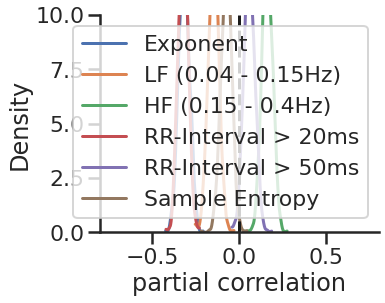

In [25]:
sns.set_style('ticks')
sns.set_context('poster')

fancy_names = dict(zip(pcorr_samples.to_dataframe().keys(), ['Exponent','LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)', 'RR-Interval > 20ms', 'RR-Interval > 50ms', 'Sample Entropy',
 ]))

_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(np.concatenate(v), plot_kwargs={'color':f'C{idx}'}, label=fancy_names[k], ax=ax)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlim(-.8, .8)
ax.set_ylim(0, 10)
ax.set_ylabel('Density')
ax.set_xlabel('partial correlation')
ax.figure.set_size_inches(5,4)
sns.despine()

In [28]:
fancy_names

{'Exponent': 'Exponent',
 'lf_fft_log': 'LF (0.04 - 0.15Hz)',
 'hf_fft_log': 'HF (0.15 - 0.4Hz)',
 'nn20': 'RR-Interval > 20ms',
 'nn50': 'RR-Interval > 50ms',
 'sampen': 'Sample Entropy'}

Text(0, 0.5, 'Density')

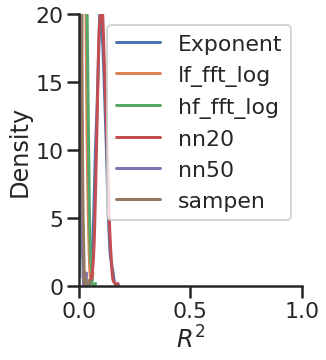

In [26]:
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(np.concatenate(v)**2, plot_kwargs={'color':f'C{idx}'}, label=k, ax=ax)
sns.despine()
#plt.legend(loc=(0.8,0.8), labels=labels); # all_variables label_names
ax.set_ylim(0, 20)
ax.set_xlim(0, 1)
ax.figure.set_size_inches(4, 5, forward=True)
plt.xlabel('$R^2$')
plt.ylabel('Density')

,label,correlation coefficient
0,Exponent,-0.355369
1,Exponent,-0.296815
2,Exponent,-0.321113
3,Exponent,-0.350751
4,Exponent,-0.248911
...,...,...
11995,Sample Entropy,-0.068009
11996,Sample Entropy,-0.045900
11997,Sample Entropy,-0.083223
11998,Sample Entropy,-0.113491


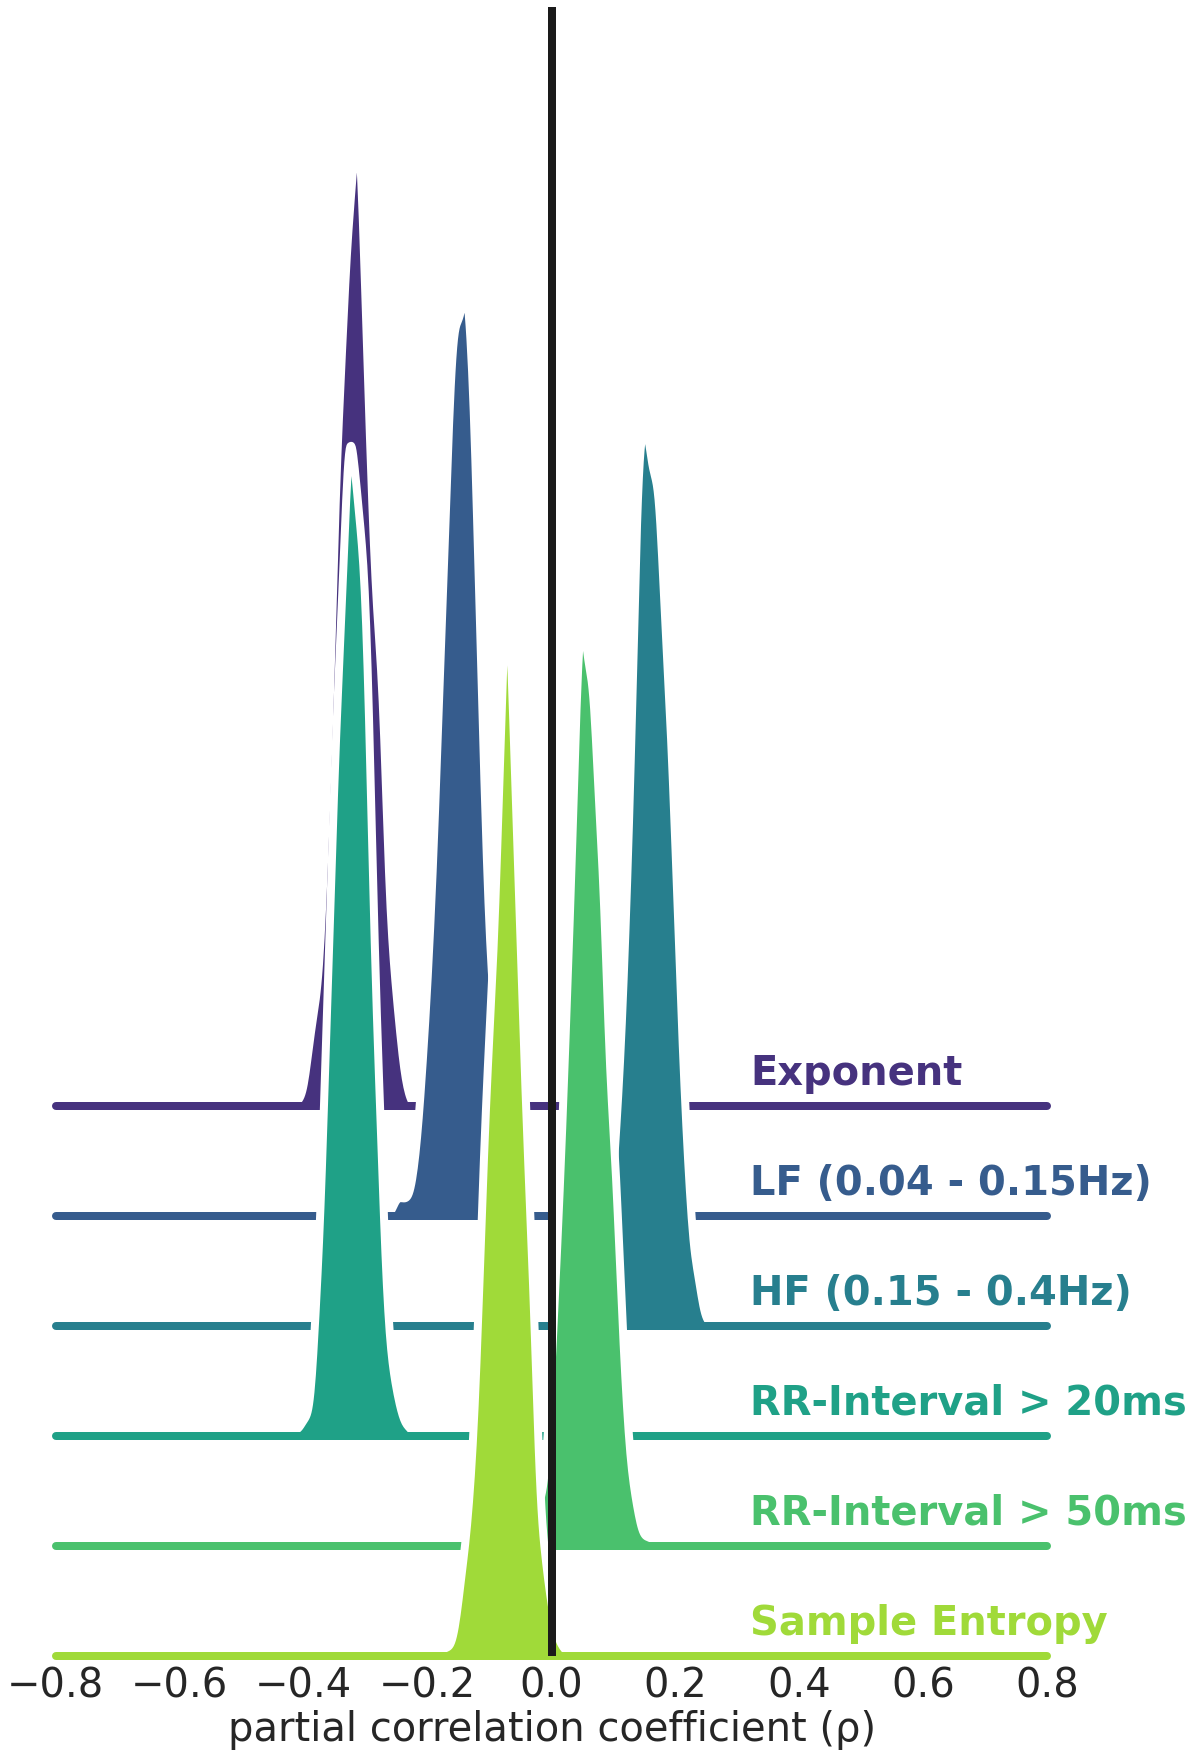

In [45]:
names_list = ['Exponent','LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)', 'RR-Interval > 20ms', 'RR-Interval > 50ms', 'Sample Entropy',]

fancy_names = dict(zip(pcorr_samples.to_dataframe().keys(), names_list))

pcorr_dict = pd.DataFrame({key: np.array(value).flatten() for key, value in pcorr_samples.items()}).melt()
pcorr_dict.columns = ['label', 'correlation coefficient']
pcorr_dict.replace(fancy_names, inplace=True)
lw=8    
    
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(pcorr_dict, row='label', hue='label',
                  aspect=4, height=4, palette='viridis', xlim=[-.7, .7])#row_order=plotting_order
g.map(sns.kdeplot, 'correlation coefficient', shade=True, alpha=1, lw=2.5)
g.map(sns.kdeplot, 'correlation coefficient', clip_on=False, color="w", lw=lw)
g.map(plt.axhline, y=0, lw=lw, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.axvline(x=0, color='k', linestyle='-', lw=lw)
    ax.text(0.7, 0.03, label, size=40, fontweight="bold", color=color,
        ha="left", va="center", transform=ax.transAxes)
    ax.set_ylabel('')
    
g.map(label, 'label')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.9)
g.axes[0,0].set_xlabel('axes label 1')
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set_xlabels('partial correlation coefficient (\u03C1)', fontsize=40, fontweight='roman')
g.set_xticklabels(fontsize=40, fontweight='roman')
g.despine(bottom=True, left=True)

g.fig.figure.savefig('./results/partial_corr_pred_age.svg')

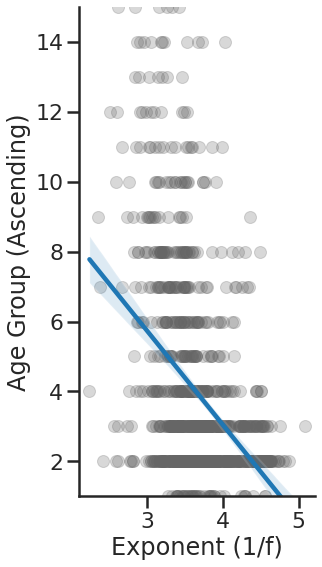

In [23]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


sns.set_style('ticks') #'darkgrid', {"axes.facecolor": ".9"}

g = sns.lmplot(data=df_cmb, x='Exponent', y='Age_group', #hue='Device', #col='Device',
               #line_kws={'color': '#34558b'}, 
               scatter_kws={'color': '#666666', 'alpha': 0.25})

g.axes[0][0].set_ylabel('Age Group (Ascending)')
g.axes[0][0].set_xlabel('Exponent (1/f)')
g.axes[0][0].set_ylim(0.5, 15)
#g.axes[0][1].set_xlabel('Exponent (1/f)')
g.ax.figure.set_size_inches(5, 10, forward=True)
g.figure.savefig('./results/ecg_only_age.svg')

In [44]:
pg.corr(df_cmb['Exponent'], df_cmb['Age_group'])

,n,r,CI95%,p-val,BF10,power
pearson,1043,-0.402906,"[-0.45, -0.35]",5.552219e-42,3.577e+38,1.0


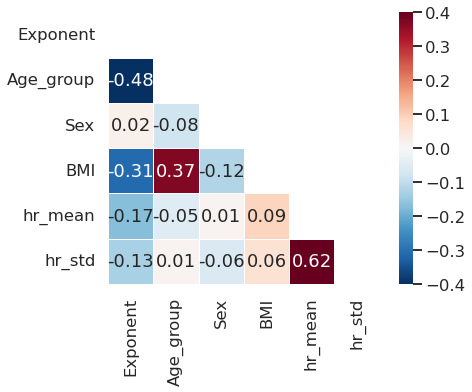

In [107]:
df_corr = d_0[['Exponent','Age_group', 'Sex', 'BMI', 'hr_mean', 'hr_std']].corr()

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    g = sns.heatmap(df_corr.round(decimals=2), vmax=0.4, vmin=-.4, 
                annot=True, linewidths=1, square=True, 
                cmap='RdBu_r', mask=mask)
    
g.figure.savefig('./results/corr_d1_features.svg', bbox_inches='tight')

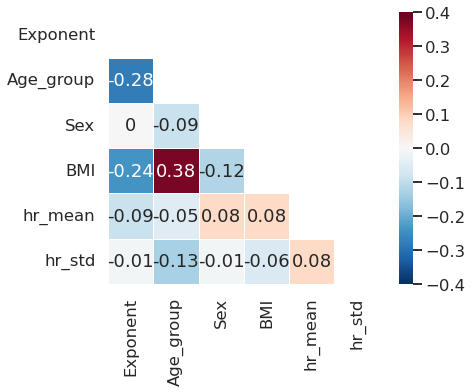

In [32]:
df_corr = d_0[['Exponent','Age_group', 'Sex', 'BMI', 'hr_mean', 'hr_std']].corr()

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    g = sns.heatmap(df_corr.round(decimals=2), vmax=0.4, vmin=-.4, 
                annot=True, linewidths=1, square=True, 
                cmap='RdBu_r', mask=mask)
    
g.figure.savefig('./results/corr_d0_features.svg', bbox_inches='tight')

In [25]:
pg.corr(d_0['Exponent'], d_0['Age_group'])

,n,r,CI95%,p-val,BF10,power
pearson,488,-0.283445,"[-0.36, -0.2]",1.809556e-10,3.6e+07,0.999996


In [26]:
pg.corr(df_cmb_clean['Exponent'], df_cmb_clean['Age_group'])

,n,r,CI95%,p-val,BF10,power
pearson,892,-0.183053,"[-0.25, -0.12]",3.669564e-08,1.566e+05,0.999817


In [31]:
pg.corr(df_cmb_clean['Age_group'], df_cmb_clean['hr_mean'])

,n,r,CI95%,p-val,BF10,power
pearson,892,-0.038626,"[-0.1, 0.03]",0.249144,0.081,0.210695


In [58]:
pg.corr(df_cmb_clean['Exponent'], df_cmb_clean['nni_mean'], method='shepherd')

LinAlgError: Singular matrix

In [1296]:
pg.corr(d_1['Exponent'], d_1['hr_std'], method='shepherd')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
shepherd,391,19,-0.001853,"[-0.1, 0.1]",0.000003,-0.005151,0.97159,0.050112
